In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

import matplotlib.pyplot as plt
import time

import data_splitter as ds
import data_loader as dl
import feature_extraction as fex
import run_model as rm
import eval_model as ev

2023-04-12 04:18:20.902270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 04:18:21.817606: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [8]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [9]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [4]:
metadata = pd.read_csv('train.csv')

## Get 25% sample

In [ ]:
# image id of all sample training set after split to calib and train set
train_img_ids = [id for k, v in splitter.trainset.items() for id in v]
print(len(train_img_ids))

In [ ]:
print('25% of sample = {} patients, {} images'.format(len(splitter.trainset.keys())*0.25, len(train_img_ids)*0.25))
print('Ratio images : patients = ', len(train_img_ids)/len(splitter.trainset.keys()))

In [ ]:
# stratified sampling 25% from the training set >> 8,751 images
sample = metadata[metadata['patient_id'].isin(splitter.trainset.keys())]
sample = sample.groupby('cancer', group_keys=False).apply(lambda x: x.sample(frac=0.25))

print(len(sample.patient_id.unique()), len(sample.image_id.unique()))

In [ ]:
X = sample.drop(columns='cancer')
y = sample.cancer

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(len(X_train), len(X_validate))

In [ ]:
sample_train_ids = X_train.image_id.unique()
sample_validate_ids = X_validate.image_id.unique()

# Trasfer learning from ImageNet

### Image Resolution 256 x 256

In [3]:
IMG_SIZE = (256, 256, 1)

inception = keras.applications.InceptionV3(
    weights='imagenet',  # load weights pre-trained on ImageNet.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 29, 29, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 29, 29, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 29, 29, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 29, 29, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 14, 14, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 14, 14, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 14, 14, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 14, 14, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 14, 14, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 14, 14, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 6, 6, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 6, 6, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 6, 6, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [8]:
# base_model.summary()
keras.utils.plot_model(inception, show_shapes=True)

In [12]:
train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

In [9]:
BATCH_SIZE = 4*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [13]:
print(len(train_gen), len(val_gen))

X, y = train_gen[0]
print(X.shape, y.shape)

218 54
(128, 256, 256, 3) (128,)


In [14]:
X, y = train_gen[0]
print(X.shape, y.shape)

(128, 256, 256, 3) (128,)


In [15]:
inception.output.shape[-3:]

TensorShape([6, 6, 2048])

## Out of the box

In [15]:
model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [20]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [21]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    #validation_data=val_generator,
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 01:15:17.801942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - ETA: 0s - loss: 0.1016 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5085 - prc: 0.0208

2023-04-07 01:20:06.136799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.14402, saving model to models/inception_imagenet_checkpoint/imagenet_adam-lr-default-01-prc0.02-tp0.0-loss0.14.hdf5
218/218 [==============================] - 374s 2s/step - loss: 0.1016 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5085 - prc: 0.0208 - val_loss: 0.1440 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6768.0000 - val_fn: 144.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4935 - val_prc: 0.0200
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.1013 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4948 - prc: 0.0200
Epoch 2: val_loss did not improve from 0.14402
218/218 [==============================] - 360s 2s/step - loss: 0.1013 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0

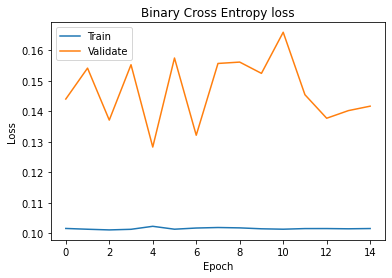

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

## Use initial bias

In [5]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
initial_bias = np.log([pos/neg])
print(initial_bias)

[-3.83388407]


In [6]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [17]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [26]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    #validation_data=val_generator,
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))

Epoch 1/100


2023-04-07 03:14:40.729266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - ETA: 0s - loss: 0.1146 - tp: 5.0000 - fp: 123.0000 - tn: 27205.0000 - fn: 571.0000 - accuracy: 0.9751 - precision: 0.0391 - recall: 0.0087 - auc: 0.5058 - prc: 0.0211

2023-04-07 03:19:28.260285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.20563, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_adam-lr-default-01-prc0.02-tp0.0-loss0.21.hdf5
218/218 [==============================] - 375s 2s/step - loss: 0.1146 - tp: 5.0000 - fp: 123.0000 - tn: 27205.0000 - fn: 571.0000 - accuracy: 0.9751 - precision: 0.0391 - recall: 0.0087 - auc: 0.5058 - prc: 0.0211 - val_loss: 0.2056 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6771.0000 - val_fn: 141.0000 - val_accuracy: 0.9796 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4906 - val_prc: 0.0193
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.1007 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4833 - prc: 0.0198
Epoch 2: val_loss improved from 0.20563 to 0.19814, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_adam-lr-default-02-prc0.02-tp0.0-loss0.20.hdf5


Epoch 12/100
218/218 [==============================] - ETA: 0s - loss: 0.1017 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4904 - prc: 0.0204
Epoch 12: val_loss did not improve from 0.17176
218/218 [==============================] - 367s 2s/step - loss: 0.1017 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4904 - prc: 0.0204 - val_loss: 0.2017 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6768.0000 - val_fn: 144.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4941 - val_prc: 0.0200
Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.1013 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4919 - prc: 0.0201
Epoch 13: val_loss did not improve fr

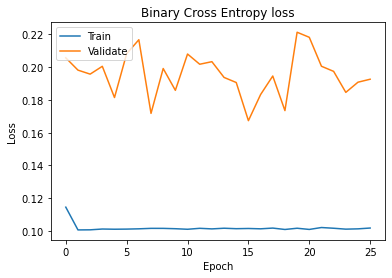

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

## Use initial bias and class weights

In [10]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [30]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [31]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weight_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))

Epoch 1/100


2023-04-07 06:13:26.813424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4765 - tp: 217.0000 - fp: 10791.0000 - tn: 23306.0000 - fn: 502.0000 - accuracy: 0.6756 - precision: 0.0197 - recall: 0.3018 - auc: 0.4915 - prc: 0.0200

2023-04-07 06:18:32.306982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.81001, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weight_adam-lr-default-01-prc0.02-tp107.0-loss0.81.hdf5
218/218 [==============================] - 399s 2s/step - loss: 0.4765 - tp: 217.0000 - fp: 10791.0000 - tn: 23306.0000 - fn: 502.0000 - accuracy: 0.6756 - precision: 0.0197 - recall: 0.3018 - auc: 0.4915 - prc: 0.0200 - val_loss: 0.8100 - val_tp: 107.0000 - val_fp: 4841.0000 - val_tn: 1928.0000 - val_fn: 36.0000 - val_accuracy: 0.2944 - val_precision: 0.0216 - val_recall: 0.7483 - val_auc: 0.5404 - val_prc: 0.0236
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4429 - tp: 302.0000 - fp: 14674.0000 - tn: 12650.0000 - fn: 278.0000 - accuracy: 0.4642 - precision: 0.0202 - recall: 0.5207 - auc: 0.4772 - prc: 0.0191
Epoch 2: val_loss improved from 0.81001 to 0.67010, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weight_adam-lr-default-02-prc0.02-tp71.0-loss0.67.hdf5
2

Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4473 - tp: 279.0000 - fp: 14057.0000 - tn: 13269.0000 - fn: 299.0000 - accuracy: 0.4855 - precision: 0.0195 - recall: 0.4827 - auc: 0.4834 - prc: 0.0199
Epoch 13: val_loss did not improve from 0.41508
218/218 [==============================] - 382s 2s/step - loss: 0.4473 - tp: 279.0000 - fp: 14057.0000 - tn: 13269.0000 - fn: 299.0000 - accuracy: 0.4855 - precision: 0.0195 - recall: 0.4827 - auc: 0.4834 - prc: 0.0199 - val_loss: 0.7284 - val_tp: 88.0000 - val_fp: 3734.0000 - val_tn: 3034.0000 - val_fn: 56.0000 - val_accuracy: 0.4517 - val_precision: 0.0230 - val_recall: 0.6111 - val_auc: 0.5374 - val_prc: 0.0233
Epoch 14/100
218/218 [==============================] - ETA: 0s - loss: 0.4433 - tp: 263.0000 - fp: 12537.0000 - tn: 14789.0000 - fn: 315.0000 - accuracy: 0.5394 - precision: 0.0205 - recall: 0.4550 - auc: 0.4903 - prc: 0.0202
Epoch 14: val_loss did not improve from 0.41508
218/218 [=======================

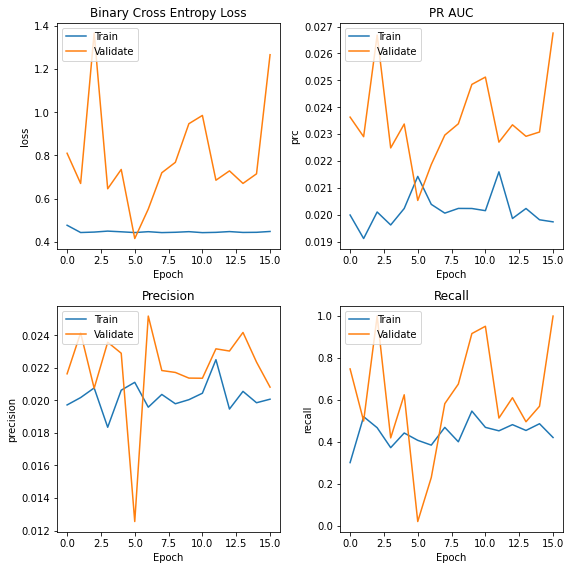

In [50]:
ev.plot_history(history)

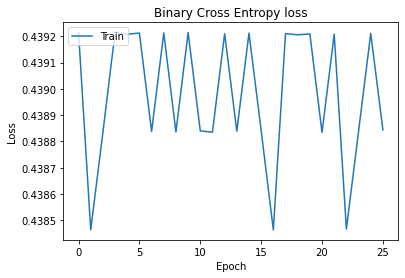

In [33]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Increase learning rate

In [18]:
LEARNING_RATE = 0.01
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 30

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/30


2023-04-07 08:24:02.519331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4958 - tp: 414.0000 - fp: 19899.0000 - tn: 14199.0000 - fn: 304.0000 - accuracy: 0.4197 - precision: 0.0204 - recall: 0.5766 - auc: 0.5014 - prc: 0.0213

2023-04-07 08:29:09.445490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.63998, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adamlr1e-2-01-prc0.03-tp143.0-loss1.64.hdf5
218/218 [==============================] - 404s 2s/step - loss: 0.4958 - tp: 414.0000 - fp: 19899.0000 - tn: 14199.0000 - fn: 304.0000 - accuracy: 0.4197 - precision: 0.0204 - recall: 0.5766 - auc: 0.5014 - prc: 0.0213 - val_loss: 1.6400 - val_tp: 143.0000 - val_fp: 6769.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0207 - val_precision: 0.0207 - val_recall: 1.0000 - val_auc: 0.5658 - val_prc: 0.0265
Epoch 2/30
218/218 [==============================] - ETA: 0s - loss: 0.4723 - tp: 287.0000 - fp: 13281.0000 - tn: 14046.0000 - fn: 290.0000 - accuracy: 0.5137 - precision: 0.0212 - recall: 0.4974 - auc: 0.5125 - prc: 0.0217
Epoch 2: val_loss improved from 1.63998 to 0.58442, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adamlr1e-2-02-prc0.02-tp42.0-loss0.58.hdf5
218/21

218/218 [==============================] - 384s 2s/step - loss: 0.4907 - tp: 288.0000 - fp: 12896.0000 - tn: 14430.0000 - fn: 290.0000 - accuracy: 0.5275 - precision: 0.0218 - recall: 0.4983 - auc: 0.5064 - prc: 0.0203 - val_loss: 0.1353 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6768.0000 - val_fn: 144.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4770 - val_prc: 0.0189
Epoch 13/30
218/218 [==============================] - ETA: 0s - loss: 0.5161 - tp: 287.0000 - fp: 13025.0000 - tn: 14301.0000 - fn: 291.0000 - accuracy: 0.5228 - precision: 0.0216 - recall: 0.4965 - auc: 0.5100 - prc: 0.0213
Epoch 13: val_loss did not improve from 0.13529
218/218 [==============================] - 391s 2s/step - loss: 0.5161 - tp: 287.0000 - fp: 13025.0000 - tn: 14301.0000 - fn: 291.0000 - accuracy: 0.5228 - precision: 0.0216 - recall: 0.4965 - auc: 0.5100 - prc: 0.0213 - val_loss: 2.2117 - val_tp: 144.0000 - val_fp: 6768.0000 - val_tn: 0.0000e+

Epoch 24/30
218/218 [==============================] - ETA: 0s - loss: 0.4668 - tp: 249.0000 - fp: 12679.0000 - tn: 14646.0000 - fn: 330.0000 - accuracy: 0.5338 - precision: 0.0193 - recall: 0.4301 - auc: 0.4874 - prc: 0.0198
Epoch 24: val_loss did not improve from 0.13194
218/218 [==============================] - 495s 2s/step - loss: 0.4668 - tp: 249.0000 - fp: 12679.0000 - tn: 14646.0000 - fn: 330.0000 - accuracy: 0.5338 - precision: 0.0193 - recall: 0.4301 - auc: 0.4874 - prc: 0.0198 - val_loss: 1.5158 - val_tp: 141.0000 - val_fp: 6768.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0208 - val_precision: 0.0204 - val_recall: 1.0000 - val_auc: 0.5708 - val_prc: 0.0269
Epoch 25/30
218/218 [==============================] - ETA: 0s - loss: 0.4909 - tp: 279.0000 - fp: 12393.0000 - tn: 14933.0000 - fn: 299.0000 - accuracy: 0.5452 - precision: 0.0220 - recall: 0.4827 - auc: 0.5046 - prc: 0.0206
Epoch 25: val_loss did not improve from 0.13194
218/218 [========================

In [19]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

2023-04-07 22:41:19.193947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
218/218 [==============================] - ETA: 0s - loss: 0.4779 - tp: 310.0000 - fp: 13386.0000 - tn: 13938.0000 - fn: 270.0000 - accuracy: 0.5106 - precision: 0.0226 - recall: 0.5345 - auc: 0.5257 - prc: 0.0227

2023-04-07 22:46:16.531444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.79571, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-2-01-prc0.02-tp91.0-loss0.80.hdf5
218/218 [==============================] - 383s 2s/step - loss: 0.4779 - tp: 310.0000 - fp: 13386.0000 - tn: 13938.0000 - fn: 270.0000 - accuracy: 0.5106 - precision: 0.0226 - recall: 0.5345 - auc: 0.5257 - prc: 0.0227 - val_loss: 0.7957 - val_tp: 91.0000 - val_fp: 4511.0000 - val_tn: 2257.0000 - val_fn: 53.0000 - val_accuracy: 0.3397 - val_precision: 0.0198 - val_recall: 0.6319 - val_auc: 0.4982 - val_prc: 0.0209
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4845 - tp: 251.0000 - fp: 12677.0000 - tn: 14652.0000 - fn: 324.0000 - accuracy: 0.5341 - precision: 0.0194 - recall: 0.4365 - auc: 0.4921 - prc: 0.0210
Epoch 2: val_loss did not improve from 0.79571
218/218 [==============================] - 373s 2s/step - loss: 0.4845 - tp: 251.0000 - fp: 12677.0000 - tn: 14652.0000 - fn: 324.0000 - 

Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4912 - tp: 286.0000 - fp: 14050.0000 - tn: 13276.0000 - fn: 292.0000 - accuracy: 0.4860 - precision: 0.0199 - recall: 0.4948 - auc: 0.4962 - prc: 0.0202
Epoch 13: val_loss did not improve from 0.17442
218/218 [==============================] - 372s 2s/step - loss: 0.4912 - tp: 286.0000 - fp: 14050.0000 - tn: 13276.0000 - fn: 292.0000 - accuracy: 0.4860 - precision: 0.0199 - recall: 0.4948 - auc: 0.4962 - prc: 0.0202 - val_loss: 0.2636 - val_tp: 1.0000 - val_fp: 13.0000 - val_tn: 6755.0000 - val_fn: 143.0000 - val_accuracy: 0.9774 - val_precision: 0.0714 - val_recall: 0.0069 - val_auc: 0.4634 - val_prc: 0.0194
Epoch 14/100
218/218 [==============================] - ETA: 0s - loss: 0.4934 - tp: 279.0000 - fp: 12905.0000 - tn: 14418.0000 - fn: 302.0000 - accuracy: 0.5267 - precision: 0.0212 - recall: 0.4802 - auc: 0.5049 - prc: 0.0211
Epoch 14: val_loss did not improve from 0.17442
218/218 [=========================

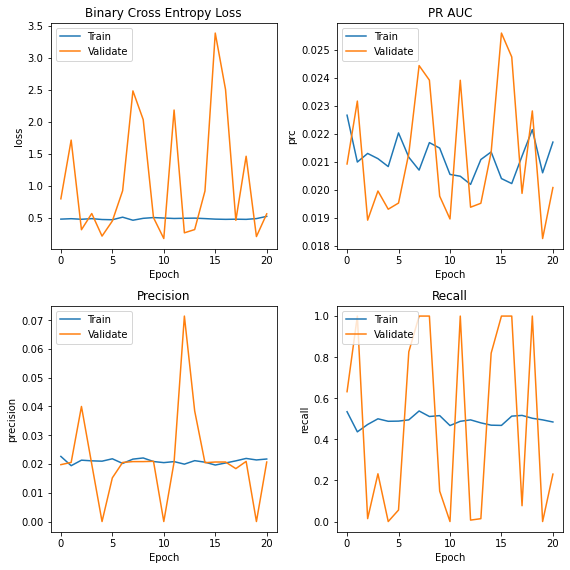

In [20]:
ev.plot_history(history)

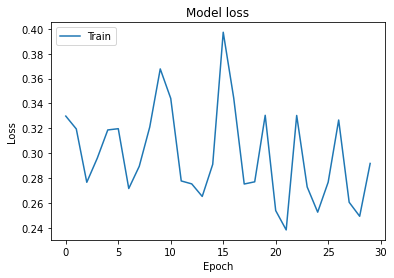

In [28]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Freeze and save weights from epoch 19 which has the lowest validation loss for predictions

In [19]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/selected_models/imagenet_256_bias_weights_adamlr1e-2-19-prc0.02-tp0.0-loss0.13.hdf5')

model.trainable = False
model.save('../predictive_models/inception_imagenet_checkpoint/selected_models/imagenet_256_batch128_adam_lr1e-2_epoch19_frozen.hdf5')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 0
Non-trainable params: 21,804,833
_________________________________________________________________


### Decreasing learning rate

In [21]:
LEARNING_RATE = 0.00001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [22]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-08 03:20:44.287901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4425 - tp: 33.0000 - fp: 1562.0000 - tn: 32531.0000 - fn: 690.0000 - accuracy: 0.9353 - precision: 0.0207 - recall: 0.0456 - auc: 0.5006 - prc: 0.0207

2023-04-08 03:25:45.312732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.69065, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-5-01-prc0.02-tp68.0-loss0.69.hdf5
218/218 [==============================] - 399s 2s/step - loss: 0.4425 - tp: 33.0000 - fp: 1562.0000 - tn: 32531.0000 - fn: 690.0000 - accuracy: 0.9353 - precision: 0.0207 - recall: 0.0456 - auc: 0.5006 - prc: 0.0207 - val_loss: 0.6906 - val_tp: 68.0000 - val_fp: 3210.0000 - val_tn: 3558.0000 - val_fn: 76.0000 - val_accuracy: 0.5246 - val_precision: 0.0207 - val_recall: 0.4722 - val_auc: 0.4927 - val_prc: 0.0206
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5013 - prc: 0.0208
Epoch 2: val_loss did not improve from 0.69065
218/218 [==============================] - 374s 2s/step - loss: 0.4398 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 5

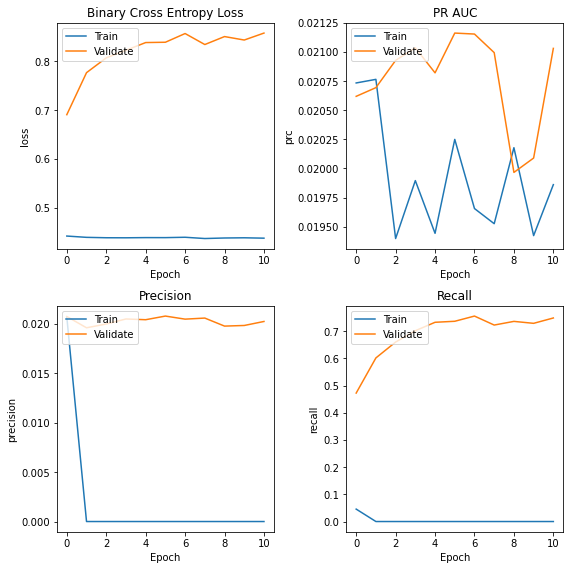

In [23]:
ev.plot_history(history)

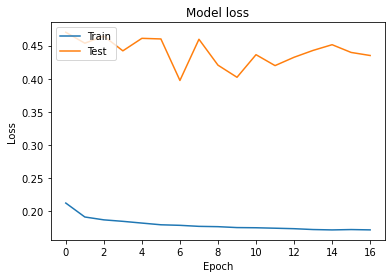

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Decrease further

In [26]:
LEARNING_RATE = 0.000001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [27]:
model.load_weights('../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-6-38-prc0.02-tp104.0-loss0.84.hdf5')

In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-08 08:49:24.123681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206
Epoch 1: val_loss improved from inf to 0.85039, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-6-01-prc0.02-tp105.0-loss0.85.hdf5
218/218 [==============================] - 386s 2s/step - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206 - val_loss: 0.8504 - val_tp: 105.0000 - val_fp: 5107.0000 - val_tn: 1663.0000 - val_fn: 37.0000 - val_accuracy: 0.2558 - val_precision: 0.0201 - val_recall: 0.7394 - val_auc: 0.5051 - val_prc: 0.0210
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision:

Epoch 11/100
218/218 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 11: val_loss did not improve from 0.84513
218/218 [==============================] - 394s 2s/step - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.8455 - val_tp: 105.0000 - val_fp: 5054.0000 - val_tn: 1715.0000 - val_fn: 38.0000 - val_accuracy: 0.2633 - val_precision: 0.0204 - val_recall: 0.7343 - val_auc: 0.5016 - val_prc: 0.0210
Epoch 12/100
218/218 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 12: val_loss improved from 0.84513 to 0.844

Epoch 22/100
218/218 [==============================] - ETA: 0s - loss: 0.4384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 22: val_loss did not improve from 0.84105
218/218 [==============================] - 400s 2s/step - loss: 0.4384 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.8415 - val_tp: 104.0000 - val_fp: 5017.0000 - val_tn: 1753.0000 - val_fn: 38.0000 - val_accuracy: 0.2687 - val_precision: 0.0203 - val_recall: 0.7324 - val_auc: 0.4977 - val_prc: 0.0207
Epoch 23/100
218/218 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 23: val_loss did not improve from 0.84105
2

Epoch 33/100
218/218 [==============================] - ETA: 0s - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208
Epoch 33: val_loss did not improve from 0.83965
218/218 [==============================] - 443s 2s/step - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208 - val_loss: 0.8399 - val_tp: 106.0000 - val_fp: 4997.0000 - val_tn: 1771.0000 - val_fn: 38.0000 - val_accuracy: 0.2716 - val_precision: 0.0208 - val_recall: 0.7361 - val_auc: 0.5018 - val_prc: 0.0212
Epoch 34/100
218/218 [==============================] - ETA: 0s - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208
Epoch 34: val_loss did not improve from 0.83965
2

In [28]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-09 03:39:10.396387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207

2023-04-09 03:44:14.436685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.83753, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-6-01-prc0.02-tp104.0-loss0.84.hdf5
218/218 [==============================] - 397s 2s/step - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.8375 - val_tp: 104.0000 - val_fp: 4987.0000 - val_tn: 1783.0000 - val_fn: 38.0000 - val_accuracy: 0.2730 - val_precision: 0.0204 - val_recall: 0.7324 - val_auc: 0.5004 - val_prc: 0.0208
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4399 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27323.0000 - fn: 581.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0208
Epoch 2: val_loss did not improve from 0.83753
218/218 [==============================] - 380s 2s/step - loss: 0.4399 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 2732

Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206
Epoch 13: val_loss did not improve from 0.83730
218/218 [==============================] - 374s 2s/step - loss: 0.4381 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27328.0000 - fn: 576.0000 - accuracy: 0.9794 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0206 - val_loss: 0.8376 - val_tp: 105.0000 - val_fp: 4989.0000 - val_tn: 1781.0000 - val_fn: 37.0000 - val_accuracy: 0.2729 - val_precision: 0.0206 - val_recall: 0.7394 - val_auc: 0.5060 - val_prc: 0.0211
Epoch 14/100
218/218 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 14: val_loss did not improve from 0.83730
2

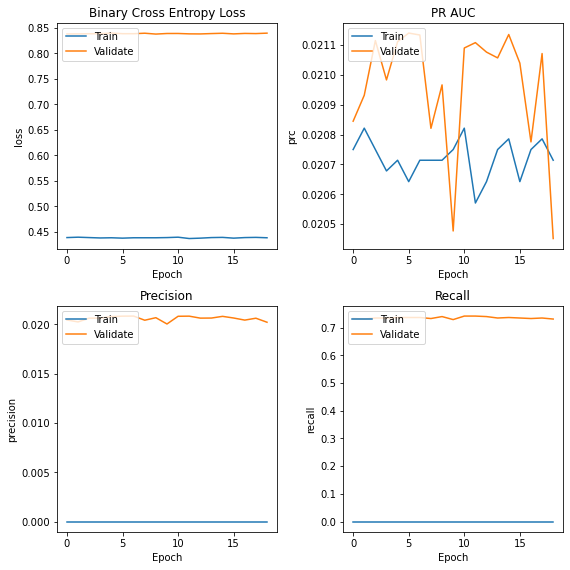

In [29]:
ev.plot_history(history)

### Try learning rate 0.0001

In [34]:
LEARNING_RATE = 0.0001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-09 10:56:58.945057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


875/875 [==============================] - ETA: 0s - loss: 0.4405 - tp: 358.0000 - fp: 17034.0000 - tn: 17185.0000 - fn: 367.0000 - accuracy: 0.5020 - precision: 0.0206 - recall: 0.4938 - auc: 0.4917 - prc: 0.0204

2023-04-09 11:01:27.528804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.98207, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-4-01-prc0.02-tp126.0-loss0.98.hdf5
875/875 [==============================] - 353s 383ms/step - loss: 0.4405 - tp: 358.0000 - fp: 17034.0000 - tn: 17185.0000 - fn: 367.0000 - accuracy: 0.5020 - precision: 0.0206 - recall: 0.4938 - auc: 0.4917 - prc: 0.0204 - val_loss: 0.9821 - val_tp: 126.0000 - val_fp: 6082.0000 - val_tn: 718.0000 - val_fn: 18.0000 - val_accuracy: 0.1215 - val_precision: 0.0203 - val_recall: 0.8750 - val_auc: 0.5088 - val_prc: 0.0214
Epoch 2/100
875/875 [==============================] - ETA: 0s - loss: 0.4401 - tp: 254.0000 - fp: 12194.0000 - tn: 15226.0000 - fn: 326.0000 - accuracy: 0.5529 - precision: 0.0204 - recall: 0.4379 - auc: 0.4932 - prc: 0.0203
Epoch 2: val_loss improved from 0.98207 to 0.91072, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-4-02-prc0.02-tp116.0-loss0.91.hdf5
875/

In [23]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-09 01:15:17.070753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


218/218 [==============================] - ETA: 0s - loss: 0.4395 - tp: 311.0000 - fp: 15157.0000 - tn: 18937.0000 - fn: 411.0000 - accuracy: 0.5528 - precision: 0.0201 - recall: 0.4307 - auc: 0.4847 - prc: 0.0202

2023-04-09 01:20:16.172097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.79310, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_adam-lr1e-4-01-prc0.02-tp91.0-loss0.79.hdf5
218/218 [==============================] - 387s 2s/step - loss: 0.4395 - tp: 311.0000 - fp: 15157.0000 - tn: 18937.0000 - fn: 411.0000 - accuracy: 0.5528 - precision: 0.0201 - recall: 0.4307 - auc: 0.4847 - prc: 0.0202 - val_loss: 0.7931 - val_tp: 91.0000 - val_fp: 4478.0000 - val_tn: 2290.0000 - val_fn: 53.0000 - val_accuracy: 0.3445 - val_precision: 0.0199 - val_recall: 0.6319 - val_auc: 0.4985 - val_prc: 0.0209
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4402 - tp: 77.0000 - fp: 4147.0000 - tn: 23177.0000 - fn: 503.0000 - accuracy: 0.8334 - precision: 0.0182 - recall: 0.1328 - auc: 0.4762 - prc: 0.0194
Epoch 2: val_loss did not improve from 0.79310
218/218 [==============================] - 374s 2s/step - loss: 0.4402 - tp: 77.0000 - fp: 4147.0000 - tn: 23177.0000 - fn: 503.0000 - accu

Epoch 13/100
218/218 [==============================] - ETA: 0s - loss: 0.4391 - tp: 188.0000 - fp: 9412.0000 - tn: 17915.0000 - fn: 389.0000 - accuracy: 0.6488 - precision: 0.0196 - recall: 0.3258 - auc: 0.4847 - prc: 0.0197
Epoch 13: val_loss did not improve from 0.72424
218/218 [==============================] - 371s 2s/step - loss: 0.4391 - tp: 188.0000 - fp: 9412.0000 - tn: 17915.0000 - fn: 389.0000 - accuracy: 0.6488 - precision: 0.0196 - recall: 0.3258 - auc: 0.4847 - prc: 0.0197 - val_loss: 0.7932 - val_tp: 87.0000 - val_fp: 4476.0000 - val_tn: 2296.0000 - val_fn: 53.0000 - val_accuracy: 0.3448 - val_precision: 0.0191 - val_recall: 0.6214 - val_auc: 0.4944 - val_prc: 0.0201
Epoch 14/100
218/218 [==============================] - ETA: 0s - loss: 0.4397 - tp: 166.0000 - fp: 7642.0000 - tn: 19683.0000 - fn: 413.0000 - accuracy: 0.7113 - precision: 0.0213 - recall: 0.2867 - auc: 0.4987 - prc: 0.0210
Epoch 14: val_loss did not improve from 0.72424
218/218 [==========================

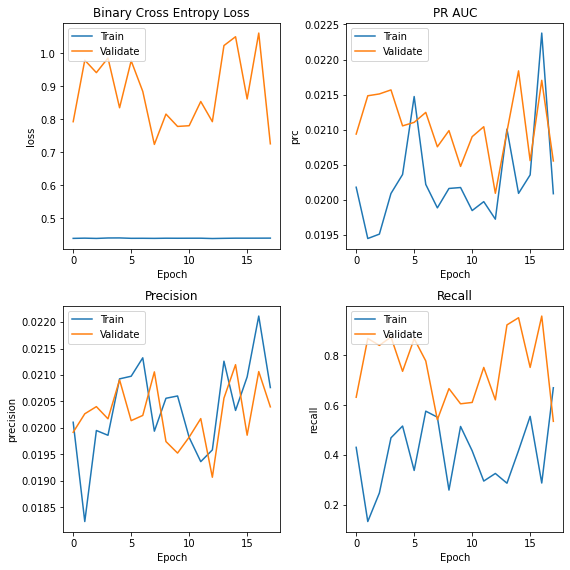

In [25]:
ev.plot_history(history)

### Reduce batch size from 4 x 32 to 1 x 32

In [30]:
BATCH_SIZE = 1*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        n_classes=2,
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [ ]:
LEARNING_RATE = 0.0001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

In [31]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch32_adam-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-09 07:40:23.947616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


875/875 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27419.0000 - fn: 581.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207

2023-04-09 07:44:44.153573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.83947, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch32_adam-lr1e-4-01-prc0.02-tp106.0-loss0.84.hdf5
875/875 [==============================] - 335s 374ms/step - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27419.0000 - fn: 581.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.8395 - val_tp: 106.0000 - val_fp: 5017.0000 - val_tn: 1783.0000 - val_fn: 38.0000 - val_accuracy: 0.2720 - val_precision: 0.0207 - val_recall: 0.7361 - val_auc: 0.5022 - val_prc: 0.0211
Epoch 2/100
875/875 [==============================] - ETA: 0s - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27421.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 2: val_loss did not improve from 0.83947
875/875 [==============================] - 335s 373ms/step - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e

Epoch 23/100
875/875 [==============================] - ETA: 0s - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27421.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 23: val_loss did not improve from 0.83837
875/875 [==============================] - 345s 382ms/step - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27421.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.8385 - val_tp: 106.0000 - val_fp: 5015.0000 - val_tn: 1785.0000 - val_fn: 38.0000 - val_accuracy: 0.2723 - val_precision: 0.0207 - val_recall: 0.7361 - val_auc: 0.5020 - val_prc: 0.0210
Epoch 24/100
875/875 [==============================] - ETA: 0s - loss: 0.4388 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27420.0000 - fn: 580.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 24: val_loss did not improve from 0.8383

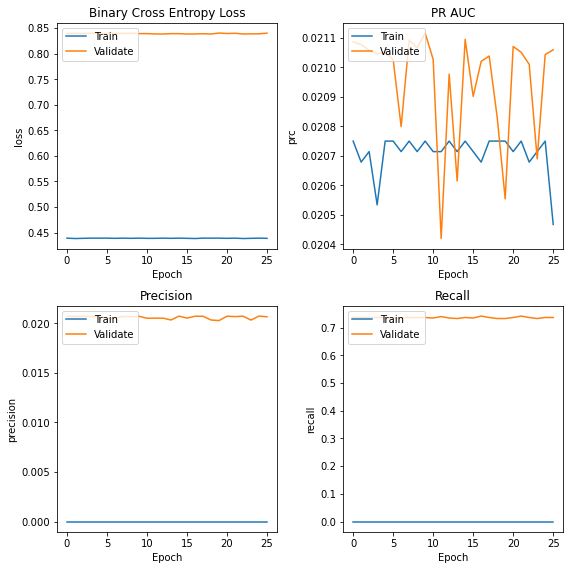

In [32]:
ev.plot_history(history)

### Increase batch size from 4 x 32 to 8 x 32

In [16]:
BATCH_SIZE = 8*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [17]:
LEARNING_RATE = 0.0001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predicitve_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_adam-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-11 00:04:50.011129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4402 - tp: 314.0000 - fp: 15302.0000 - tn: 12023.0000 - fn: 265.0000 - accuracy: 0.4421 - precision: 0.0201 - recall: 0.5423 - auc: 0.4928 - prc: 0.0201

2023-04-11 00:10:40.670448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.55520, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_adam-lr1e-4-01-prc0.02-tp14.0-loss0.56.hdf5
109/109 [==============================] - 505s 4s/step - loss: 0.4402 - tp: 314.0000 - fp: 15302.0000 - tn: 12023.0000 - fn: 265.0000 - accuracy: 0.4421 - precision: 0.0201 - recall: 0.5423 - auc: 0.4928 - prc: 0.0201 - val_loss: 0.5552 - val_tp: 14.0000 - val_fp: 965.0000 - val_tn: 5804.0000 - val_fn: 129.0000 - val_accuracy: 0.8417 - val_precision: 0.0143 - val_recall: 0.0979 - val_auc: 0.4850 - val_prc: 0.0188
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4401 - tp: 206.0000 - fp: 10290.0000 - tn: 17034.0000 - fn: 374.0000 - accuracy: 0.6178 - precision: 0.0196 - recall: 0.3552 - auc: 0.4763 - prc: 0.0193
Epoch 2: val_loss improved from 0.55520 to 0.55053, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_adam-lr1e-4-02-prc0.02-tp13.0-loss0

109/109 [==============================] - 436s 4s/step - loss: 0.4394 - tp: 217.0000 - fp: 10791.0000 - tn: 16534.0000 - fn: 362.0000 - accuracy: 0.6003 - precision: 0.0197 - recall: 0.3748 - auc: 0.4822 - prc: 0.0197 - val_loss: 0.5209 - val_tp: 6.0000 - val_fp: 604.0000 - val_tn: 6166.0000 - val_fn: 136.0000 - val_accuracy: 0.8929 - val_precision: 0.0098 - val_recall: 0.0423 - val_auc: 0.4803 - val_prc: 0.0185
Epoch 13/100
109/109 [==============================] - ETA: 0s - loss: 0.4399 - tp: 226.0000 - fp: 11550.0000 - tn: 15775.0000 - fn: 353.0000 - accuracy: 0.5734 - precision: 0.0192 - recall: 0.3903 - auc: 0.4854 - prc: 0.0197
Epoch 13: val_loss improved from 0.51611 to 0.48106, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_adam-lr1e-4-13-prc0.02-tp2.0-loss0.48.hdf5
109/109 [==============================] - 423s 4s/step - loss: 0.4399 - tp: 226.0000 - fp: 11550.0000 - tn: 15775.0000 - fn: 353.0000 - accuracy: 0.5734 - precision: 0.019

Epoch 24/100
109/109 [==============================] - ETA: 0s - loss: 0.4393 - tp: 221.0000 - fp: 10531.0000 - tn: 16795.0000 - fn: 357.0000 - accuracy: 0.6098 - precision: 0.0206 - recall: 0.3824 - auc: 0.5035 - prc: 0.0206
Epoch 24: val_loss did not improve from 0.45426
109/109 [==============================] - 423s 4s/step - loss: 0.4393 - tp: 221.0000 - fp: 10531.0000 - tn: 16795.0000 - fn: 357.0000 - accuracy: 0.6098 - precision: 0.0206 - recall: 0.3824 - auc: 0.5035 - prc: 0.0206 - val_loss: 0.5854 - val_tp: 24.0000 - val_fp: 1343.0000 - val_tn: 5426.0000 - val_fn: 119.0000 - val_accuracy: 0.7885 - val_precision: 0.0176 - val_recall: 0.1678 - val_auc: 0.4862 - val_prc: 0.0189
Epoch 25/100
109/109 [==============================] - ETA: 0s - loss: 0.4401 - tp: 190.0000 - fp: 9538.0000 - tn: 17786.0000 - fn: 390.0000 - accuracy: 0.6442 - precision: 0.0195 - recall: 0.3276 - auc: 0.4852 - prc: 0.0200
Epoch 25: val_loss did not improve from 0.45426
109/109 [=======================

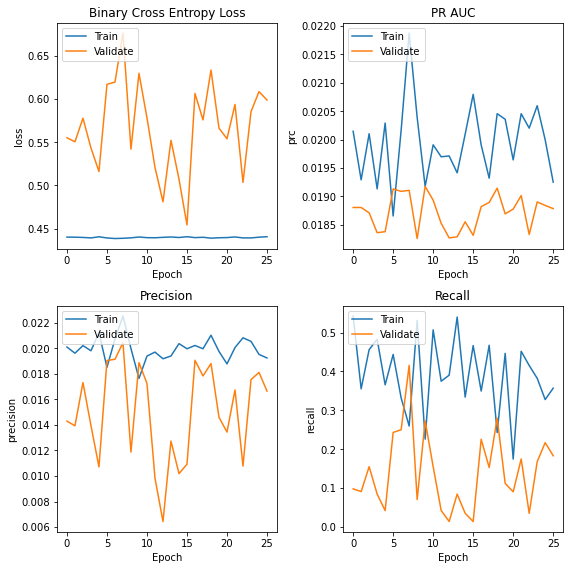

In [19]:
ev.plot_history(history)

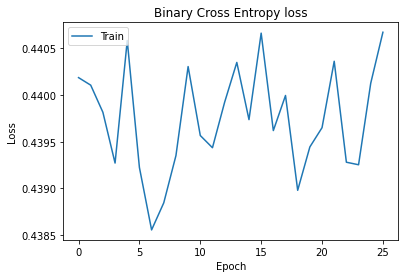

In [20]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

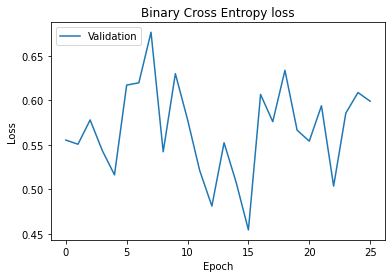

In [21]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Plot gradient

In [16]:
%load_ext tensorboard

In [20]:
from keras.callbacks import TensorBoard
import os

log_basepath = '../logs' # directory to keep training logs
model_name = 'imagenet_256_bias_weight_adam-lr-1e-5'

model_log_path = log_basepath + model_name
os.makedirs(model_log_path, exist_ok=True)

tensorboard = TensorBoard(
    log_dir=model_log_path,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch'
)

In [13]:
BATCH_SIZE = 8*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
)

In [14]:
LEARNING_RATE = 0.00001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder created:  models/inception_imagenet_checkpoint/sgd
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [23]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_adam-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, early_stopping, tensorboard],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

2023-04-09 21:44:44.592081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 0.4463 - tp: 581.0000 - fp: 27323.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1.0000 - auc: 0.5007 - prc: 0.0212

2023-04-09 21:50:20.689390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.74860, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_adam-lr1e-5-01-prc0.02-tp81.0-loss0.75.hdf5
109/109 [==============================] - 455s 4s/step - loss: 0.4463 - tp: 581.0000 - fp: 27323.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0208 - precision: 0.0208 - recall: 1.0000 - auc: 0.5007 - prc: 0.0212 - val_loss: 0.7486 - val_tp: 81.0000 - val_fp: 3949.0000 - val_tn: 2820.0000 - val_fn: 62.0000 - val_accuracy: 0.4197 - val_precision: 0.0201 - val_recall: 0.5664 - val_auc: 0.4861 - val_prc: 0.0195
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4414 - tp: 579.0000 - fp: 27325.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0207 - precision: 0.0207 - recall: 1.0000 - auc: 0.4800 - prc: 0.0197
Epoch 2: val_loss improved from 0.74860 to 0.64409, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_adam-lr1e-5-02-prc0.02-tp48.0-l

Process Keras_worker_ForkPoolWorker-2599:
Process Keras_worker_ForkPoolWorker-2606:
Process Keras_worker_ForkPoolWorker-2609:
Process Keras_worker_ForkPoolWorker-2610:
Process Keras_worker_ForkPoolWorker-2616:
Process Keras_worker_ForkPoolWorker-2605:
Process Keras_worker_ForkPoolWorker-2623:
Process Keras_worker_ForkPoolWorker-2603:
Process Keras_worker_ForkPoolWorker-2611:
Process Keras_worker_ForkPoolWorker-2598:
Process Keras_worker_ForkPoolWorker-2607:
Process Keras_worker_ForkPoolWorker-2613:
Process Keras_worker_ForkPoolWorker-2612:
Process Keras_worker_ForkPoolWorker-2596:
Traceback (most recent call last):
Process Keras_worker_ForkPoolWorker-2621:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Process Keras_worker_ForkPoolWorker-2618:
Process Keras_worker_ForkPoolWorker-2597:
Traceback (most recent call last):
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.

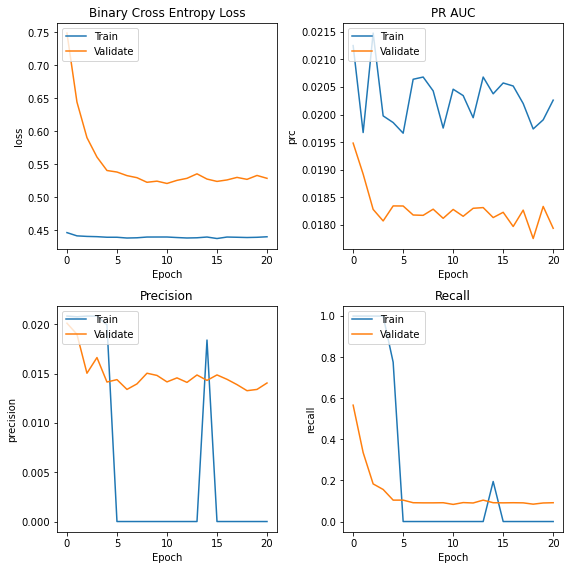

In [26]:
ev.plot_history(history)

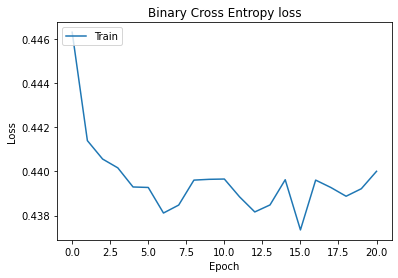

In [27]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [19]:
logdir = 'logsimagenet_256_bias_weight_adam-lr-1e-5 '
%tensorboard --logdir logs

### Freeze and save weights from epoch 11 which has the lowest validation loss for predictions

In [20]:
model.load_weights('../predicitive_models/inception_imagenet_checkpoint/selected_models/imagenet_256_bias_weights_batch256_adam-lr1e-5-11-prc0.02-tp12.0-loss0.52.hdf5')

model.trainable = False
model.save('../predictive_models/inception_imagenet_checkpoint/selected_models/imagenet_256_batch256_adam_lr1e-5_epoch11_frozen.hdf5')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 0
Non-trainable params: 21,804,833
_________________________________________________________________


### No early stopping

In [20]:
from keras.callbacks import TensorBoard
import os

log_basepath = '../logs'
model_name = 'imagenet_256_bias_weight_batch256_no-earlystop_adam-lr-1e-5'

model_log_path = log_basepath + model_name
os.makedirs(model_log_path, exist_ok=True)

tensorboard = TensorBoard(
    log_dir=model_log_path,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch'
)

In [13]:
BATCH_SIZE = 8*32 
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory storing the preprocessed images of the training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
)

In [14]:
LEARNING_RATE = 0.00001
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predicitve_models/inception_imagenet_checkpoint/sgd'
)

model.summary()

Checkpoint path:  models/inception_imagenet_checkpoint/sgd
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

#early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_no-earlystop_adam-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)


history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint, tensorboard],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-10 00:57:38.635815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4427 - tp: 576.0000 - fp: 27328.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0206 - precision: 0.0206 - recall: 1.0000 - auc: 0.4921 - prc: 0.0197

2023-04-10 01:03:02.766703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.77561, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_no-earlystop_adam-lr1e-5-01-prc0.02-tp89.0-loss0.78.hdf5
109/109 [==============================] - 454s 4s/step - loss: 0.4427 - tp: 576.0000 - fp: 27328.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0206 - precision: 0.0206 - recall: 1.0000 - auc: 0.4921 - prc: 0.0197 - val_loss: 0.7756 - val_tp: 89.0000 - val_fp: 4534.0000 - val_tn: 2235.0000 - val_fn: 54.0000 - val_accuracy: 0.3362 - val_precision: 0.0193 - val_recall: 0.6224 - val_auc: 0.5133 - val_prc: 0.0241
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4396 - tp: 576.0000 - fp: 27328.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.0206 - precision: 0.0206 - recall: 1.0000 - auc: 0.5105 - prc: 0.0213
Epoch 2: val_loss improved from 0.77561 to 0.68507, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_no-earlystop_adam-

109/109 [==============================] - ETA: 0s - loss: 0.4393 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4911 - prc: 0.0204
Epoch 22: val_loss improved from 0.58396 to 0.58386, saving model to models/inception_imagenet_checkpoint/imagenet_256_bias_weights_batch256_no-earlystop_adam-lr1e-5-22-prc0.02-tp30.0-loss0.58.hdf5
109/109 [==============================] - 442s 4s/step - loss: 0.4393 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4911 - prc: 0.0204 - val_loss: 0.5839 - val_tp: 30.0000 - val_fp: 1317.0000 - val_tn: 5453.0000 - val_fn: 112.0000 - val_accuracy: 0.7933 - val_precision: 0.0223 - val_recall: 0.2113 - val_auc: 0.4900 - val_prc: 0.0211
Epoch 23/100
109/109 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - ac

Epoch 33/100
109/109 [==============================] - ETA: 0s - loss: 0.4386 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4850 - prc: 0.0194
Epoch 33: val_loss did not improve from 0.58109
109/109 [==============================] - 432s 4s/step - loss: 0.4386 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4850 - prc: 0.0194 - val_loss: 0.5814 - val_tp: 32.0000 - val_fp: 1283.0000 - val_tn: 5485.0000 - val_fn: 112.0000 - val_accuracy: 0.7982 - val_precision: 0.0243 - val_recall: 0.2222 - val_auc: 0.4977 - val_prc: 0.0229
Epoch 34/100
109/109 [==============================] - ETA: 0s - loss: 0.4396 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27324.0000 - fn: 580.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4957 - prc: 0.0203
Epoch 34: val_loss did not improve from 0.58109
1

Epoch 56/100
109/109 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 56: val_loss did not improve from 0.57705
109/109 [==============================] - 420s 4s/step - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.5965 - val_tp: 35.0000 - val_fp: 1479.0000 - val_tn: 5291.0000 - val_fn: 107.0000 - val_accuracy: 0.7705 - val_precision: 0.0231 - val_recall: 0.2465 - val_auc: 0.4987 - val_prc: 0.0226
Epoch 57/100
109/109 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4894 - prc: 0.0198
Epoch 57: val_loss did not improve from 0.57705
1

Epoch 68/100
109/109 [==============================] - ETA: 0s - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 68: val_loss did not improve from 0.57705
109/109 [==============================] - 425s 4s/step - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207 - val_loss: 0.5835 - val_tp: 32.0000 - val_fp: 1316.0000 - val_tn: 5454.0000 - val_fn: 110.0000 - val_accuracy: 0.7937 - val_precision: 0.0237 - val_recall: 0.2254 - val_auc: 0.4982 - val_prc: 0.0227
Epoch 69/100
109/109 [==============================] - ETA: 0s - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4912 - prc: 0.0202
Epoch 69: val_loss did not improve from 0.57705
1

Epoch 80/100
109/109 [==============================] - ETA: 0s - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4889 - prc: 0.0198
Epoch 80: val_loss did not improve from 0.57705
109/109 [==============================] - 445s 4s/step - loss: 0.4392 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27325.0000 - fn: 579.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4889 - prc: 0.0198 - val_loss: 0.5900 - val_tp: 34.0000 - val_fp: 1399.0000 - val_tn: 5370.0000 - val_fn: 109.0000 - val_accuracy: 0.7818 - val_precision: 0.0237 - val_recall: 0.2378 - val_auc: 0.5008 - val_prc: 0.0228
Epoch 81/100
109/109 [==============================] - ETA: 0s - loss: 0.4385 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0207
Epoch 81: val_loss did not improve from 0.57705
1

Epoch 92/100
109/109 [==============================] - ETA: 0s - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4939 - prc: 0.0204
Epoch 92: val_loss did not improve from 0.57705
109/109 [==============================] - 456s 4s/step - loss: 0.4389 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4939 - prc: 0.0204 - val_loss: 0.5954 - val_tp: 36.0000 - val_fp: 1465.0000 - val_tn: 5304.0000 - val_fn: 107.0000 - val_accuracy: 0.7726 - val_precision: 0.0240 - val_recall: 0.2517 - val_auc: 0.5013 - val_prc: 0.0229
Epoch 93/100
 41/109 [==========>...................] - ETA: 2:48 - loss: 0.4355 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 10282.0000 - fn: 214.0000 - accuracy: 0.9796 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - prc: 0.0204